In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## train.csv
PRODUCT_ID : 제품의 고유 ID  
Y_Class : 제품 품질 상태(Target)   
0 : 적정 기준 미달 (부적합)  
1 : 적합  
2 : 적정 기준 초과 (부적합)  
Y_Quality : 제품 품질 관련 정량적 수치  
TIMESTAMP : 제품이 공정에 들어간 시각  
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304','T100306' 'T010306', 'T010305' 존재)   
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)  
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수  

In [3]:
"""

  Label : Y_Quality
  Samples : Product_code , x_n, Line, timestamp

  Y_Class :  Y_Quality
  class 0 : ~ 0.525067
  class 1 : 0.530253 ~ 0.534843
  class 2 : 0.534843 ~ 
  
"""
product_lst = ['A_31','T_31','O_31']
line_lst = ['T050304', 'T050307', 'T100304','T100306' ,'T010306', 'T010305']

quality_df = train_df.loc[:,['Y_Class','Y_Quality']]
quality_group = quality_df.groupby('Y_Class').describe()
quality_group.head()

Y_Quality                                                              \
            count      mean       std       min       25%       50%       75%   
Y_Class                                                                         
0            88.0  0.520837  0.004603  0.500856  0.519440  0.522054  0.524113   
1           407.0  0.530253  0.002444  0.525086  0.528378  0.530308  0.532129   
2           103.0  0.542031  0.008038  0.534951  0.536354  0.538508  0.546555   

                   
              max  
Y_Class            
0        0.525067  
1        0.534843  
2        0.578841

In [4]:
columns_list = train_df.columns.tolist()
columns_list_test = test_df.columns.tolist()
print(columns_list)

['PRODUCT_ID', 'Y_Class', 'Y_Quality', 'TIMESTAMP', 'LINE', 'PRODUCT_CODE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56', 'X_57', 'X_58', 'X_59', 'X_60', 'X_61', 'X_62', 'X_63', 'X_64', 'X_65', 'X_66', 'X_67', 'X_68', 'X_69', 'X_70', 'X_71', 'X_72', 'X_73', 'X_74', 'X_75', 'X_76', 'X_77', 'X_78', 'X_79', 'X_80', 'X_81', 'X_82', 'X_83', 'X_84', 'X_85', 'X_86', 'X_87', 'X_88', 'X_89', 'X_90', 'X_91', 'X_92', 'X_93', 'X_94', 'X_95', 'X_96', 'X_97', 'X_98', 'X_99', 'X_100', 'X_101', 'X_102', 'X_103', 'X_104', 'X_105', 'X_106', 'X_107', 'X_108', 'X_109', 'X_110', 'X_111', 'X_112', 'X_113', 'X_114', 'X_115

In [5]:
test_df.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
"""
  X_~에 해당하는 비식별화 된 변수가 어떠한 train에도 없는 경우
  count가 0인 X 변수 제거
"""
count_0 = []
count_0_test = []
for column in columns_list:
  if train_df[column].count() == 0.0:
    count_0.append(column)
for column in columns_list_test:
  if test_df[column].count() == 0.0:
    count_0_test.append(column)
sync = []
for column in count_0:
  if column in count_0_test:
    sync.append(column)
print(f"Size of count 0 columns in train: {len(count_0)}")
print(f"Size of count 0 columns in test : {len(count_0_test)}")
print(f"0 count in both csv : {sync}")
print(f"0 count in both csv len : {len(sync)}")

Size of count 0 columns in train: 82
Size of count 0 columns in test : 506
0 count in both csv : []
0 count in both csv len : 0


In [7]:
train_nonzero_df = train_df.drop(sync,axis = 1)
test_nonzero_df = test_df.drop(sync, axis = 1)

print(f"Dataframe shape : {train_nonzero_df.shape}")
print(f"test_data shape : {test_nonzero_df.shape}")

Dataframe shape : (598, 2881)
test_data shape : (310, 2879)


#Processing train.csv

In [8]:
y_total = train_nonzero_df['Y_Class']
x_total = train_nonzero_df.drop(['Y_Quality','TIMESTAMP','PRODUCT_ID'], axis = 1)
for idx, prd in enumerate(product_lst):
  x_total.loc[x_total['PRODUCT_CODE'] == prd ,'PRODUCT_CODE'] = idx
for idx, lined in enumerate(line_lst):
  x_total.loc[x_total['LINE'] == lined, 'LINE'] = idx

print(f'shape x_total : {x_total.shape}  y_total : {y_total.shape}')

shape x_total : (598, 2878)  y_total : (598,)


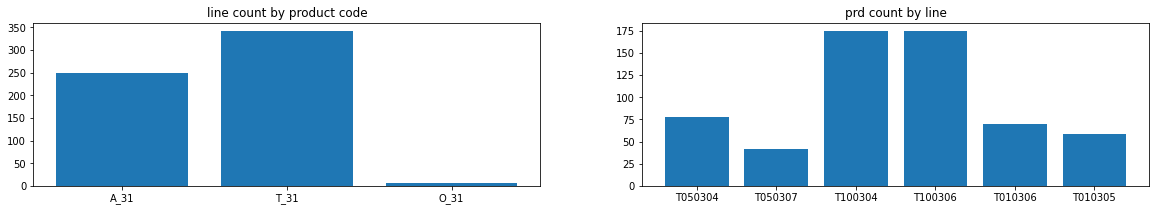

In [9]:
# visualization line count by product line
prd_count_df = x_total.groupby('PRODUCT_CODE').count()
lnd_count_df = x_total.groupby('LINE').count()
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.bar(range(3), prd_count_df['LINE'])
plt.xticks(range(3),labels = product_lst)
plt.title("line count by product code")

plt.subplot(1,2,2)
plt.bar(range(len(line_lst)), lnd_count_df['PRODUCT_CODE'])
plt.xticks(range(len(line_lst)),labels = line_lst)
plt.title("prd count by line")
plt.show()

In [40]:
# A_31에서 count가 0 이 아닌 비식별화된 변수값
prd_ex_df = x_total
prd_ex_df = prd_ex_df.drop(['LINE','PRODUCT_CODE'], axis = 1)
prd_ex_df.head()

,Y_Class,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


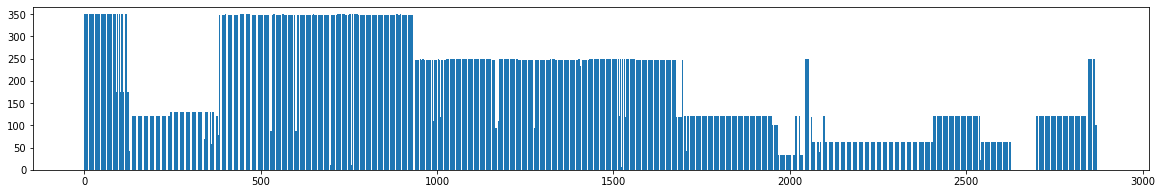

In [41]:
# same product
# line에 따라서 품질이 달라지나..?

prd_ex_df_cnt = prd_ex_df.drop(['Y_Class'],axis = 1).count()
plt.figure(figsize=(20,3))
plt.bar(range(len(prd_ex_df_cnt)),prd_ex_df_cnt)
plt.show()

In [42]:
# 데이터가 아예 존재하지 않는 비식별된 column
prd_ex_df_cnt_lst = prd_ex_df_cnt.tolist()
used_column = ['Y_Class']
for i in range(len(prd_ex_df_cnt_lst)):
  if prd_ex_df_cnt_lst[i] != 0:
    used_column.append(f"X_{i+1}")
print(used_column)
print(f"used column : {len(used_column)}")

['Y_Class', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56', 'X_57', 'X_58', 'X_59', 'X_60', 'X_61', 'X_62', 'X_63', 'X_64', 'X_65', 'X_66', 'X_67', 'X_68', 'X_69', 'X_70', 'X_71', 'X_72', 'X_73', 'X_74', 'X_75', 'X_76', 'X_77', 'X_78', 'X_79', 'X_80', 'X_81', 'X_82', 'X_83', 'X_84', 'X_85', 'X_86', 'X_87', 'X_88', 'X_89', 'X_90', 'X_91', 'X_92', 'X_93', 'X_94', 'X_95', 'X_96', 'X_97', 'X_98', 'X_99', 'X_100', 'X_101', 'X_102', 'X_103', 'X_104', 'X_105', 'X_106', 'X_107', 'X_108', 'X_109', 'X_110', 'X_111', 'X_112', 'X_113', 'X_114', 'X_115', 'X_116', 'X_117', 'X_118', 'X_119', 'X_120', 'X_121', 'X_122'

In [96]:
#product code == 0 인경우에만 학습 시도
prd_train_na0 = prd_ex_df[used_column]
prd_train_na0.head()

,Y_Class,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


In [74]:
print(len(prd_train_na0))

598


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [75]:
train_X = torch.FloatTensor(prd_train_na0[:550].drop(['Y_Class'], axis = 1).values).view(550,1,-1).to(device)
train_y = torch.LongTensor(prd_train_na0[:550]['Y_Class'].values).to(device)
test_X = torch.FloatTensor(prd_train_na0[550:].drop(['Y_Class'], axis = 1).values).view(48,1,-1).to(device)
test_y = torch.LongTensor(prd_train_na0[550:]['Y_Class'].values).to(device)
print(f"Shape : {train_X.shape} {train_y.shape} {test_X.shape} {test_y.shape}")

Shape : torch.Size([550, 1, 2793]) torch.Size([550]) torch.Size([48, 1, 2793]) torch.Size([48])


In [48]:
class LSTM(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim, num_layers,dropout):
    super(LSTM,self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.dropout = dropout

    self.lstm = nn.LSTM(input_size = input_dim, 
                        hidden_size = hidden_dim,
                        num_layers = num_layers,
                        bias = True,
                        dropout = self.dropout,
                        batch_first = True)
    self.linear2 = nn.Linear(hidden_dim,20)
    self.linear = nn.Linear(20, output_dim)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, x):
    h_0 = torch.zeros(x.size(0), self.hidden_dim)
    c_0 = torch.zeros(x.size(0), self.hidden_dim)
    
    out, (hn, cn) = self.lstm(x)
    out = self.relu(hn)
    out = out[0].view(-1, self.hidden_dim) # flatten
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear(out)
    return out

In [76]:
"""
  product_code_df -> list of product code dataframe
  line_code_df -> list of line code dataframe
"""
"""product code hyperparameters"""
input_size = 2793
hidden_size = 512
output_size = 3
lr = 0.01
num_epochs = 3000

print("Input size : {}\nOutput size : {}\n".format(input_size, output_size))

Input size : 2793
Output size : 3



In [77]:
model = LSTM(input_size, output_size, hidden_size,1,0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [78]:
for epoch in range(num_epochs+1):
  outputs = model.forward(train_X).to(device) # 전방향 학습
  optimizer.zero_grad()
  loss = criterion(outputs, train_y) # 오차 계산
  loss.backward() # 기울기 계산
      
  optimizer.step() # 오차 업데이트
  if epoch % 100 == 0:
    print(f'epoch: {epoch}  loss : {loss.item()}')

epoch: 0  loss : 1.0447388887405396
epoch: 100  loss : 0.6278712153434753
epoch: 200  loss : 0.5709639191627502
epoch: 300  loss : 0.5485028028488159
epoch: 400  loss : 0.5415801405906677
epoch: 500  loss : 0.5385928750038147
epoch: 600  loss : 0.5372592806816101
epoch: 700  loss : 0.5339022278785706
epoch: 800  loss : 0.5332465767860413
epoch: 900  loss : 0.532185435295105
epoch: 1000  loss : 0.5315710306167603
epoch: 1100  loss : 0.5310973525047302
epoch: 1200  loss : 0.5304318070411682
epoch: 1300  loss : 0.5302389860153198
epoch: 1400  loss : 0.5293033719062805
epoch: 1500  loss : 0.528061032295227
epoch: 1600  loss : 0.5274254083633423
epoch: 1700  loss : 0.5270938873291016
epoch: 1800  loss : 0.5266523957252502
epoch: 1900  loss : 0.5266695618629456
epoch: 2000  loss : 0.5260340571403503
epoch: 2100  loss : 0.5265500545501709
epoch: 2200  loss : 0.5256410241127014
epoch: 2300  loss : 0.5257595181465149
epoch: 2400  loss : 0.525251567363739
epoch: 2500  loss : 0.5253398418426514
e

25.0 %


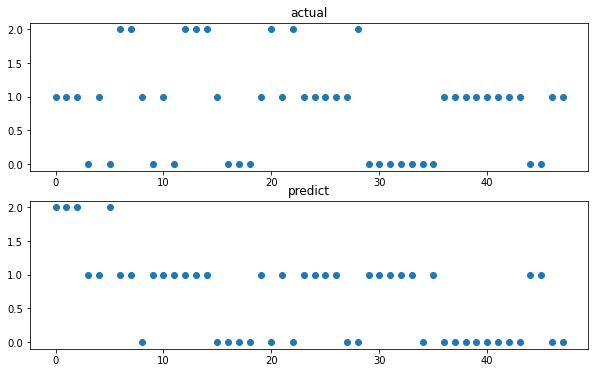

In [80]:
"""

  Label : Y_Quality
  Samples : Product_code , x_n, Line, timestamp

  Y_Class :  Y_Quality

  
"""

with torch.no_grad():
  correct = 0
  for epoch in range(num_epochs + 1):
    outputs = model(test_X)
  y_pred = torch.argmax(outputs,1).cpu().numpy()
  score = 0
  test_np = test_y.cpu().numpy()
  for i in range(len(y_pred)):
    if y_pred[i] == test_np[i]:
      score +=1
  print((score / len(y_pred)) * 100, "%")

  plt.figure(figsize=(10,6))
  plt.subplot(2,1,1)
  plt.title("actual")
  plt.scatter(range(len(test_np)), test_np)

  plt.subplot(2,1,2)
  plt.title("predict")
  plt.scatter(range(len(test_np)), y_pred)
  plt.show()
  


#########################

In [51]:
# for test data
x_total_test = test_nonzero_df.drop(['TIMESTAMP','PRODUCT_ID'], axis = 1)
for idx, prd in enumerate(product_lst):
  x_total_test.loc[x_total['PRODUCT_CODE'] == prd ,'PRODUCT_CODE'] = idx
for idx, lined in enumerate(line_lst):
  x_total_test.loc[x_total['LINE'] == lined, 'LINE'] = idx

print(f'shape x_total : {x_total_test.shape}')

shape x_total : (310, 2877)


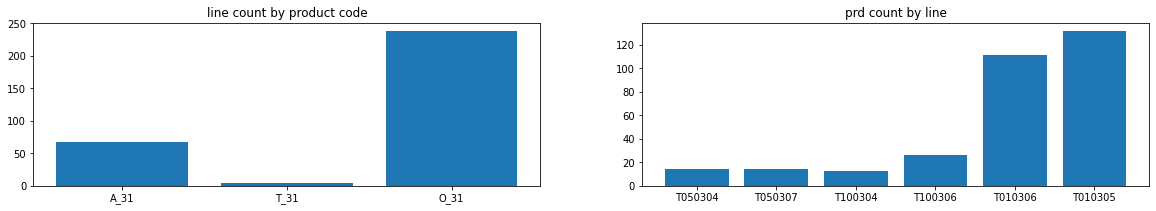

In [52]:
prd_count_test_df = x_total_test.groupby('PRODUCT_CODE').count()
lnd_count_test_df = x_total_test.groupby('LINE').count()
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.bar(range(3), prd_count_test_df['LINE'])
plt.xticks(range(3),labels = product_lst)
plt.title("line count by product code")

plt.subplot(1,2,2)
plt.bar(range(len(line_lst)), lnd_count_test_df['PRODUCT_CODE'])
plt.xticks(range(len(line_lst)),labels = line_lst)
plt.title("prd count by line")
plt.show()

#Product Code 기준으로 비식별화 변수 분석

In [ ]:
"""
  PRODUCT_CODE를 기준으로 데이터 describe
"""
code_df = train_nonzero_df.drop(['Y_Quality','Y_Class','LINE','TIMESTAMP','PRODUCT_ID'],axis = 1)
code_df = code_df.groupby('PRODUCT_CODE').count()
name_list = code_df.columns.tolist()
code_df.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
PRODUCT_CODE,,,,,,,,,,,,,,,,,,,,,
A_31,0,0,0,0,0,0,0,0,0,0,...,249,249,249,249,100,100,100,100,100,99
O_31,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
T_31,343,343,343,343,343,343,343,343,343,343,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
code_df.loc['A_31'].dropna()

X_1         0
X_2         0
X_3         0
X_4         0
X_5         0
         ... 
X_2867    100
X_2868    100
X_2869    100
X_2870    100
X_2871     99
Name: A_31, Length: 2793, dtype: int64

In [ ]:
product_code_df = [code_df.loc[df].tolist() for df in product_lst]
product_len = len(product_code_df)

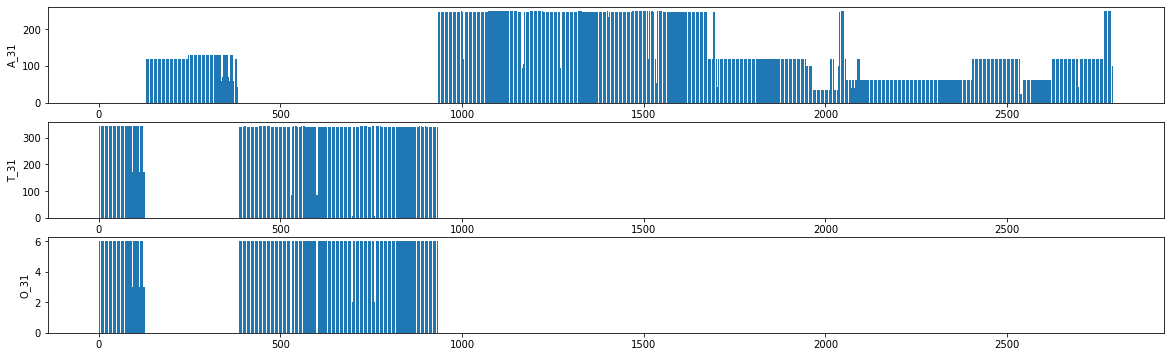

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(3,1,1)
plt.ylabel('A_31')
plt.bar(range(len(name_list)),code_df.loc['A_31'])

plt.subplot(3,1,2)
plt.ylabel('T_31')
plt.bar(range(len(name_list)),code_df.loc['T_31'])

plt.subplot(3,1,3)
plt.ylabel('O_31')
plt.bar(range(len(name_list)),code_df.loc['O_31'])
plt.show()

#Line Code 기준

In [ ]:
"""
  PRODUCT_CODE를 기준으로 데이터 describe
"""
code_df = train_nonzero_df.drop(['Y_Quality','Y_Class','PRODUCT_CODE','TIMESTAMP','PRODUCT_ID'],axis = 1)
code_df = code_df.groupby('LINE').count()
code_df.head()
name_list = code_df.columns.tolist()

In [ ]:
line_code_df = [code_df.loc[df].tolist for df in line_lst]
line_len = len(line_code_df)

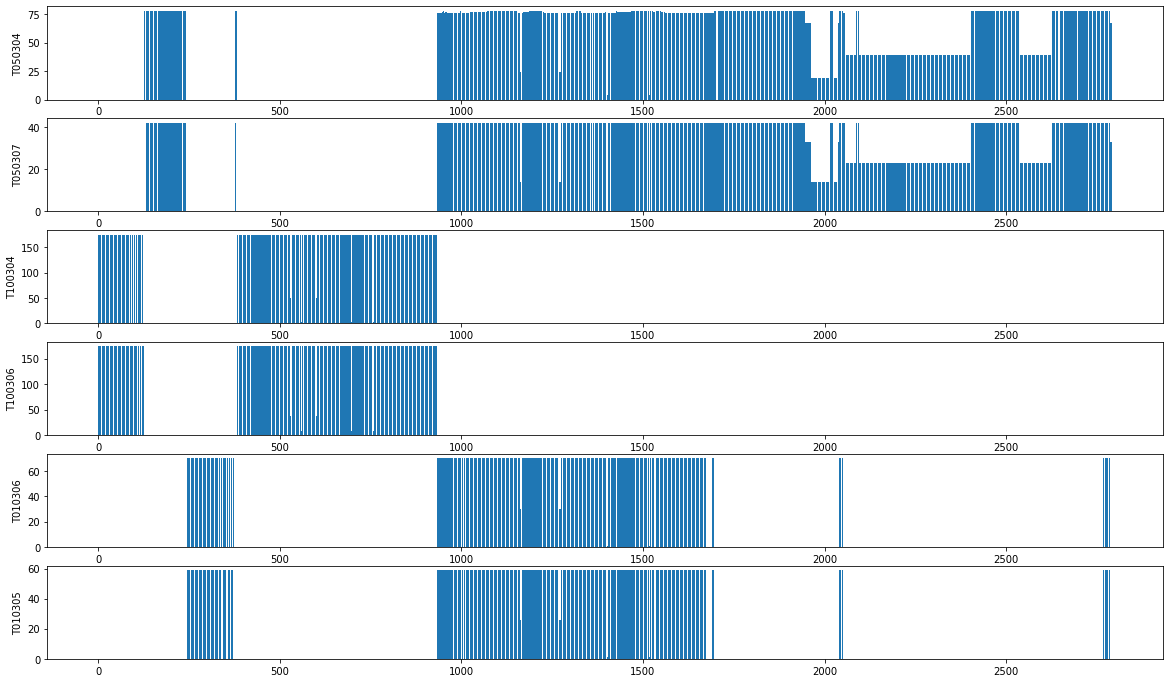

In [ ]:
plt.figure(figsize=(20,12))
for idx, li in enumerate(line_lst):
  plt.subplot(6,1,idx+1)
  plt.ylabel(li)
  plt.bar(range(len(name_list)),code_df.loc[li])
plt.show()

#DL Class

In [ ]:
train_dfs = train_nonzero_df.drop(['PRODUCT_ID','TIMESTAMP','Y_Class'],axis = 1).dropna()
ans_df = train_nonzero_df['Y_Class'])
for idx , pro in enumerate(product_lst):
  train_dfs.loc[train_dfs['PRODUCT_CODE'] == pro ,'PRODUCT_CODE'] = idx+1
for idx , li in enumerate(line_lst):
  train_dfs.loc[train_dfs['LINE'] == li, 'LINE'] = idx + 1
train_dfs.head()

SyntaxError: ignored

In [ ]:
train_dfs = train_dfs.fillna(-1)
test_dfs = test_dfs.fillna(-1)

In [ ]:
train_dfs.head()

,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,0.533433,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,-1.0
1,0.541819,2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,-1.0
2,0.531267,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,-1.0
3,0.537325,2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,-1.0
4,0.531590,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,-1.0


In [ ]:
train_X = torch.FloatTensor(train_dfs.drop(['Y_Quality'], axis = 1).values).view(-1,1,2795)
train_y = torch.FloatTensor(train_dfs['Y_Quality'].values)
test_X = train_X[400:]
test_y = train_y[400:]
train_X = train_X[:400]
train_y = train_y[:400]

print("train_X shape : {} train_y shape : {}".format(train_X.shape, train_y.shape))

train_X shape : torch.Size([400, 1, 2795]) train_y shape : torch.Size([400])
